In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install --upgrade transformers
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import gc
from tqdm.autonotebook import tqdm

from sklearn.metrics import accuracy_score,f1_score

import sklearn

import torch
from simpletransformers.classification import ClassificationModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
train = pd.read_csv("/content/I-Sarcasm_train_.csv")
test = pd.read_csv("/content/I-Sarcasm_test_.csv")

In [5]:
train.tweet[0]

"It's been a while since I visited my grandparents.#wait"

In [6]:
test.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,933721764970057000,"Gandhis busy, Congress delays UP brainstorming...",sarcastic,sarcasm
1,1086119014131200000,George and the Ice Cream Castle - Charlie and ...,not_sarcastic,NaN
2,657671293756567000,Hartford House Delegation Scores Funding For C...,not_sarcastic,NaN
3,914242426755256000,Obama to rename tallest U.S. peak: To hear the...,not_sarcastic,NaN
4,1088604537211040000,So @elonmusk couldn’t care less I guess 🤷🏻‍♂️ ...,sarcastic,satire


In [7]:
train.isna().sum()

tweet_id            0
tweet               0
sarcasm_label       0
sarcasm_type     2298
dtype: int64

In [8]:
train["sarcasm_type"].fillna("No sarcasm",inplace=True)
train.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,992251158159765000,It's been a while since I visited my grandpare...,not_sarcastic,No sarcasm
1,1084373658745870000,Well done Monty. Mark that up as your first ev...,not_sarcastic,No sarcasm
2,812181186,@davesnyder since this is fantasy can it be an...,not_sarcastic,No sarcasm
3,1090276741329920000,Really? I don't think you know what you are ta...,not_sarcastic,No sarcasm
4,553070692682723000,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,sarcasm


In [9]:
test.isna().sum()

tweet_id           0
tweet              0
sarcasm_label      0
sarcasm_type     640
dtype: int64

In [10]:
test["sarcasm_type"].fillna("No sarcasm",inplace=True)
test.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,933721764970057000,"Gandhis busy, Congress delays UP brainstorming...",sarcastic,sarcasm
1,1086119014131200000,George and the Ice Cream Castle - Charlie and ...,not_sarcastic,No sarcasm
2,657671293756567000,Hartford House Delegation Scores Funding For C...,not_sarcastic,No sarcasm
3,914242426755256000,Obama to rename tallest U.S. peak: To hear the...,not_sarcastic,No sarcasm
4,1088604537211040000,So @elonmusk couldn’t care less I guess 🤷🏻‍♂️ ...,sarcastic,satire


In [11]:
# train_data=keep_uniques(train_tweets, train_data)
# test_data=keep_uniques(test_tweets, test_data)
train.drop("tweet_id",inplace=True,axis=1)

In [12]:
test.drop("tweet_id",inplace=True,axis=1)

In [13]:
# df = pd.read_csv(file_path, dtype={"col2": str})
# df['col2'] = df['col2'].astype(str)


In [14]:
train.sarcasm_type.replace("#news #live #breakingnews Premarket: Blood-letting eases for global stocks, but China smashed again","No sarcasm",inplace=True)

In [15]:
train.describe().T

,count,unique,top,freq
tweet,3577,3523,LOL...Walker is talking about education...the ...,3
sarcasm_label,3577,2,not_sarcastic,2297
sarcasm_type,3577,7,No sarcasm,2299


In [16]:
train = train.sample(frac = 1)
test = test.sample(frac = 1)

**Value counts of individual sarcasm labels**

In [17]:
train.sarcasm_label.value_counts()

not_sarcastic    2297
sarcastic        1280
Name: sarcasm_label, dtype: int64

**Countplot sarcasm_label(s)**

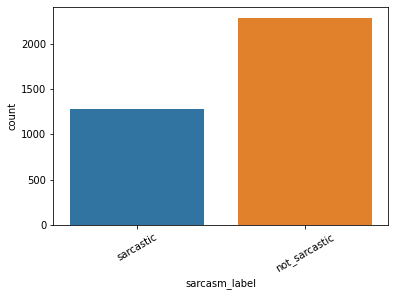

In [18]:
sns.countplot(train.sarcasm_label)
sns.set(rc={'figure.figsize':(7,8)})
plt.xticks(rotation=30);

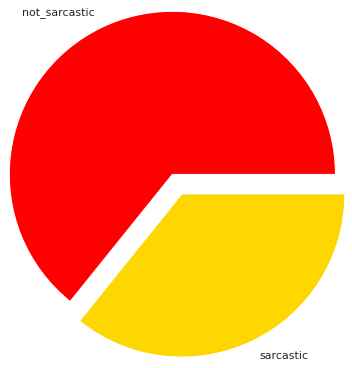

In [19]:
# pie chart using seaborn based on total count of different sentiments in training dataset 

explode = [0.1, 0.1]
train.sarcasm_label.value_counts().plot(kind='pie',explode=explode,figsize=(5,5),radius=1.5,colors=["red", "gold", "green",'blue','purple','red']);


**Value counts of individual sarcasm types**

In [20]:
train.sarcasm_type.value_counts()

No sarcasm             2299
sarcasm                 880
irony                   261
overstatement            47
rhetorical question      43
satire                   39
understatement            8
Name: sarcasm_type, dtype: int64

**Countplot of various sarcasm_type(s**

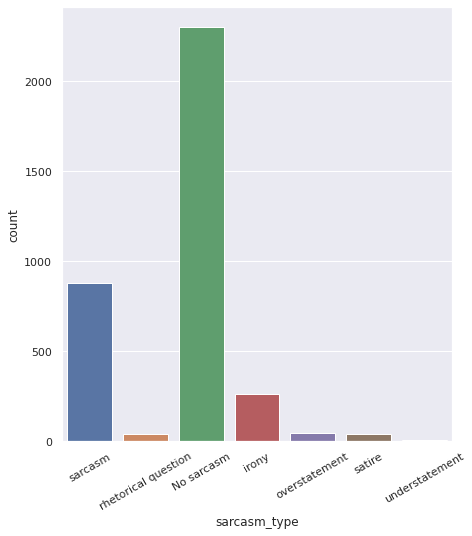

In [21]:
sns.countplot(train.sarcasm_type)
sns.color_palette("mako", as_cmap=True)

plt.xticks(rotation=30);

**Piechart depecting sarcasm_type**

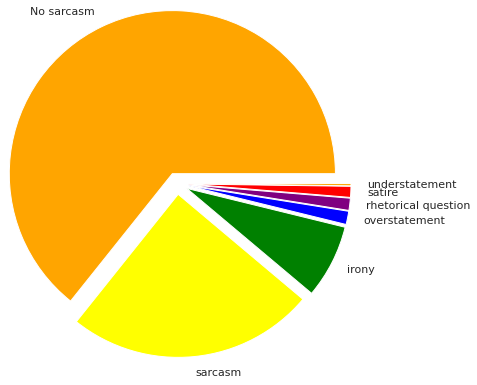

In [22]:
# pie chart using seaborn based on total count of different sentiments in training dataset 

explode = [0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1]
sns.set_theme(style="whitegrid")
train.sarcasm_type.value_counts().plot(kind='pie',explode=explode,figsize=(5,5),radius=1.5,colors=["orange", "yellow", "green",'blue','purple','red']);


In [23]:
train

,tweet,sarcasm_label,sarcasm_type
1842,"But it's ""recovering!"" #sarcasm //Home ownersh...",sarcastic,sarcasm
2039,"Welp, no sleep for me tonight. Why is the fina...",sarcastic,rhetorical question
1186,"Anchor Jorge Ramos Thrown Out of Trump Event, ...",not_sarcastic,No sarcasm
2078,Fucking Fuck Fuck Fuckety Fuck #White #Mug by ...,sarcastic,sarcasm
1838,"My recent string of luck has been wonderful, a...",sarcastic,sarcasm
...,...,...,...
1396,@aseesman hey buddy are you up? We're supposed...,not_sarcastic,No sarcasm
2566,#Missouri #Police Misconduct Still At An All T...,not_sarcastic,No sarcasm
2349,Love a long gray ponytail &amp; breeches - on ...,sarcastic,sarcasm
404,Supporters of Iran agreement feel momentum on ...,not_sarcastic,No sarcasm


In [24]:
# # Create a dataframe with the tweets data
# data = {'Tweet': train.tweet, 'Sarcasm': train.sarcasm_label}
# df = pd.DataFrame(data)

# # Create a pivot table with the sarcasm scores for each tweet
# pivot_table = df.pivot_table(index='Tweet', columns='Sarcasm', aggfunc=np.mean)

# # Create a heatmap of the pivot table
# sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')

# # Show the plot
# plt.show()


In [25]:
# # create a correlation matrix of the features
# corr = train.corr()

# # create the heatmap
# sns.heatmap(corr, annot=True, cmap='coolwarm')

# # show the plot
# plt.show()


In [26]:
def clean(tweet): 
    

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    # emoji_pattern = re.compile(
    #     '['
    #     u'\U0001F600-\U0001F64F'  # emoticons
    #     u'\U0001F300-\U0001F5FF'  # symbols & pictographs
    #     u'\U0001F680-\U0001F6FF'  # transport & map symbols
    #     u'\U0001F1E0-\U0001F1FF'  # flags
    #     u'\U00002702-\U000027B0'
    #     u'\U000024C2-\U0001F251'
    #     ']+',
    #     flags=re.UNICODE)
    # tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    # #Punctuations and special characters
    
    # tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    tweet = tweet.replace("#"," ")
    tweet = tweet.lower()
    
    # splits = tweet.split()
    # splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    # tweet = ' '.join(splits)

    
    
    return tweet

In [27]:
tqdm.pandas() 

train['tweet']= train['tweet'].progress_apply((lambda x: clean(x))) 
test['tweet'] = test['tweet'].progress_apply((lambda x: clean(x)))

  0%|          | 0/3577 [00:00<?, ?it/s]

  0%|          | 0/907 [00:00<?, ?it/s]

In [28]:
train["tweet"] = train["tweet"].apply(lambda text: re.sub(r'[^a-zA-Z0-9\s]','',text,re.I|re.A))
train.head(10)

,tweet,sarcasm_label,sarcasm_type
1842,but it is recovering sarcasm home ownership r...,sarcastic,sarcasm
2039,welp no sleep for me tonight why is the final ...,sarcastic,rhetorical question
1186,anchor jorge ramos thrown out of trump event t...,not_sarcastic,No sarcasm
2078,fucking fuck fuck fuckety fuck white mug by ...,sarcastic,sarcasm
1838,my recent string of luck has been wonderful as...,sarcastic,sarcasm
2225,it is just collateral damage a price to pay f...,sarcastic,sarcasm
2057,mourniho walking off before halftime what clas...,sarcastic,sarcasm
1000,top blogger templates blogger education in...,not_sarcastic,No sarcasm
3487,and free wifi that is a win sarcasm,sarcastic,sarcasm
323,joy davies resigns as liberal candidate over ...,not_sarcastic,No sarcasm


In [29]:
test["tweet"] = test["tweet"].apply(lambda text: re.sub(r'[^a-zA-Z0-9\s]','',text,re.I|re.A))
test.head(10)

,tweet,sarcasm_label,sarcasm_type
158,omg i have the nicest sky engineer wrongjob ...,sarcastic,sarcasm
72,this may be the party city but this party girl...,not_sarcastic,No sarcasm
701,news video obama buys cinnamon buns for repor...,not_sarcastic,No sarcasm
433,bloke just treated for smoke inhalation light...,sarcastic,irony
689,with epic parade china announces itself as the...,not_sarcastic,No sarcasm
79,sea creatures coloring pages childhood e...,not_sarcastic,No sarcasm
623,huge network politics omalley wasserman sch...,not_sarcastic,No sarcasm
328,69 days alcohol free days irony corruptmind,sarcastic,irony
849,android design android education design t...,not_sarcastic,No sarcasm
577,all the seniors from our church got called dow...,sarcastic,irony


In [30]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

train["tweet"] = train["tweet"].apply(lambda text: remove_punctuation(text))
train.head()

,tweet,sarcasm_label,sarcasm_type
1842,but it is recovering sarcasm home ownership r...,sarcastic,sarcasm
2039,welp no sleep for me tonight why is the final ...,sarcastic,rhetorical question
1186,anchor jorge ramos thrown out of trump event t...,not_sarcastic,No sarcasm
2078,fucking fuck fuck fuckety fuck white mug by ...,sarcastic,sarcasm
1838,my recent string of luck has been wonderful as...,sarcastic,sarcasm


In [31]:

# PUNCT_TO_REMOVE = string.punctuation
# def remove_punctuation(text):
#     """custom function to remove the punctuation"""
#     return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

test["tweet"] = test["tweet"].apply(lambda text: remove_punctuation(text))
test.head()

,tweet,sarcasm_label,sarcasm_type
158,omg i have the nicest sky engineer wrongjob ...,sarcastic,sarcasm
72,this may be the party city but this party girl...,not_sarcastic,No sarcasm
701,news video obama buys cinnamon buns for repor...,not_sarcastic,No sarcasm
433,bloke just treated for smoke inhalation light...,sarcastic,irony
689,with epic parade china announces itself as the...,not_sarcastic,No sarcasm


In [32]:
train.drop("sarcasm_type",inplace=True,axis=1)
test.drop("sarcasm_type",inplace=True,axis=1)


In [33]:
train = train.sort_index(ascending=True)

train.tail(10) 


,tweet,sarcasm_label
3567,obama cameron hollande merkel are all presidin...,sarcastic
3568,cnn hosts gopdebate on sept16th join us duri...,not_sarcastic
3569,video building a tower of 3000 shops bbc ne...,not_sarcastic
3570,news actuality in tweet shows escaped el ch...,not_sarcastic
3571,rx drugs oval white pill n 60 yes it is a 6...,not_sarcastic
3572,hey christine nixon people like cover every s...,not_sarcastic
3573,erythropoietin drugs market to reach 119 bil...,not_sarcastic
3574,apples first android app wants you to stop usi...,sarcastic
3575,hurry ending soon follow b4 160915 4chance2win...,not_sarcastic
3576,alcohol and drug treatment court to accept mor...,not_sarcastic


In [34]:
test = test.sort_index(ascending=True)

test.tail(10) 

,tweet,sarcasm_label
897,n korean womans family says she was kidnapped ...,not_sarcastic
898,tyonews us announces 19m in grants to expand ...,not_sarcastic
899,whitehouse fire company welcomes new engine 22...,not_sarcastic
900,new edition read todays good news online fa...,not_sarcastic
901,learn about the safety and privacy of with th...,not_sarcastic
902,this subject likely to be prominent in next g...,not_sarcastic
903,get rid your best an education suggestion,not_sarcastic
904,top blogger templates blogger education in...,not_sarcastic
905,politics and football that is what iowa does ...,not_sarcastic
906,plan to remove damaged bridge causes stir in w...,not_sarcastic


In [35]:
train.isnull().sum()

tweet            0
sarcasm_label    0
dtype: int64

In [36]:
train.shape

(3577, 2)

In [37]:
# # create a correlation matrix of the features
# corr = train["tweet"].corr(train["sarcasm_label"])

# # create the heatmap
# sns.heatmap(corr, annot=True, cmap='coolwarm')

# # show the plot
# plt.show()

In [38]:
# from transformers import pipeline

# # Instantiate the sarcasm detection model
# sarcasm_detector = pipeline('text-classification', model='distilbert-base-cased-distilled-squad')

# # Generate sarcasm scores for a list of tweets
# sarcasm_scores = sarcasm_detector(train.tweet)

# # Extract the scores from the output
# sarcasm_scores = [score['label_probability'][1] for score in sarcasm_scores]


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3577 entries, 0 to 3576
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          3577 non-null   object
 1   sarcasm_label  3577 non-null   object
dtypes: object(2)
memory usage: 83.8+ KB


In [40]:
# # Saving a DataFrame column
# train['tweet']=train['tweet'].to_string()


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3577 entries, 0 to 3576
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          3577 non-null   object
 1   sarcasm_label  3577 non-null   object
dtypes: object(2)
memory usage: 83.8+ KB


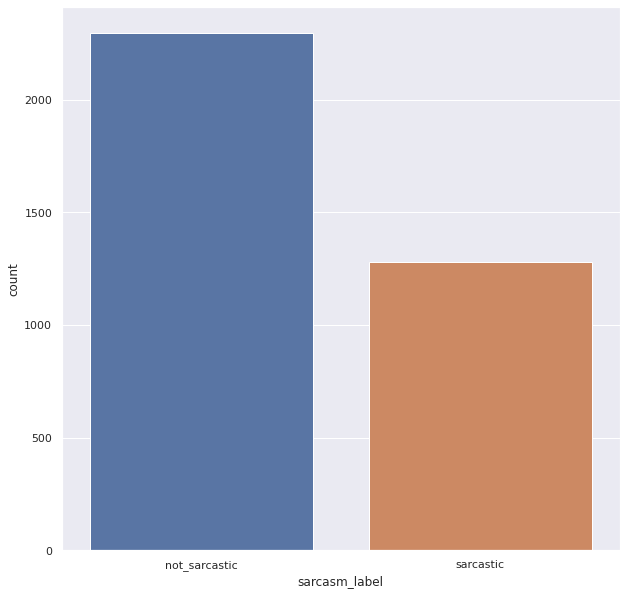

In [42]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train['sarcasm_label'])

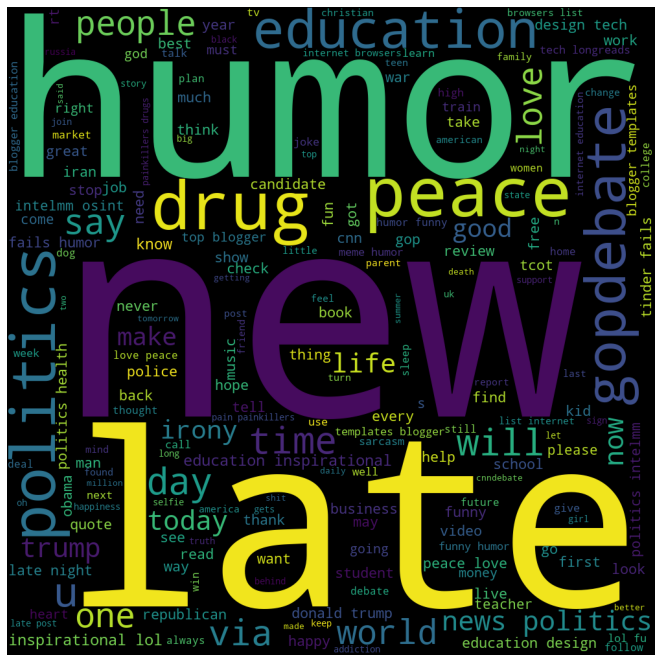

In [43]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train.tweet[train['sarcasm_label']=='not_sarcastic']:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(background_color='black',stopwords=stopwords,
                         min_font_size=5,width=1000, height=1000).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

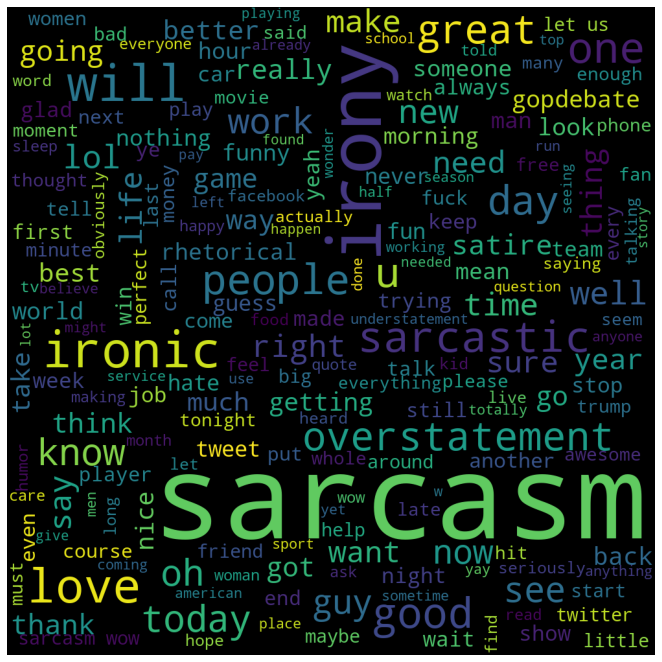

In [44]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train.tweet[train['sarcasm_label']=='sarcastic']:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(
                         background_color='black',stopwords=stopwords,
                         min_font_size=5,width=1000, height=1000).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

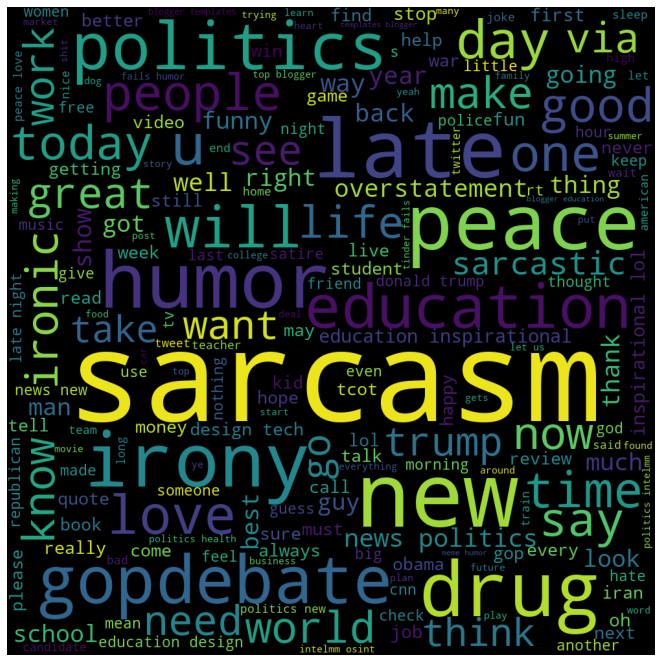

In [45]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train.tweet:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(width=1000,height=1000,
                         background_color='black',stopwords=stopwords,
                         min_font_size=5).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

In [46]:
train

,tweet,sarcasm_label
0,it is been a while since i visited my grandpar...,not_sarcastic
1,well done monty mark that up as your first eve...,not_sarcastic
2,since this is fantasy can it be any individua...,not_sarcastic
3,really i do not think you know what you are ta...,not_sarcastic
4,missed toughenough tonight no worries just wa...,sarcastic
...,...,...
3572,hey christine nixon people like cover every s...,not_sarcastic
3573,erythropoietin drugs market to reach 119 bil...,not_sarcastic
3574,apples first android app wants you to stop usi...,sarcastic
3575,hurry ending soon follow b4 160915 4chance2win...,not_sarcastic


In [47]:
# Concatenate all sarcastic tweets into one string
sarcastic_tweets = train[train['sarcasm_label'] == 'sarcastic']['tweet'].tolist()
sarcastic_text = " ".join(sarcastic_tweets)

# Concatenate all non-sarcastic tweets into one string
non_sarcastic_tweets = train[train['sarcasm_label'] == 'not_sarcastic']['tweet'].tolist()
non_sarcastic_text = " ".join(non_sarcastic_tweets)

# Generate the wordclouds
sarcastic_wordcloud = WordCloud().generate(sarcastic_text)
non_sarcastic_wordcloud = WordCloud().generate(non_sarcastic_text)

# Access the words_ attribute to get the frequencies of the words
sarcastic_word_frequencies = sarcastic_wordcloud.words_
non_sarcastic_word_frequencies = non_sarcastic_wordcloud.words_

# Sort the dictionaries by frequency to get the most frequent words
sarcastic_sorted_words = sorted(sarcastic_word_frequencies.items(), key=lambda x: x[1], reverse=True)
non_sarcastic_sorted_words = sorted(non_sarcastic_word_frequencies.items(), key=lambda x: x[1], reverse=True)

# Print the most frequent words in sarcastic tweets
print("Most frequent words in sarcastic tweets:")
for word, frequency in sarcastic_sorted_words[:10]:
    print(f"{word}: {frequency}")

# Print the most frequent words in non-sarcastic tweets
print("Most frequent words in non-sarcastic tweets:")
for word, frequency in non_sarcastic_sorted_words[:10]:
    print(f"{word}: {frequency}")

Most frequent words in sarcastic tweets:
sarcasm: 1.0
irony: 0.2496894409937888
ironic: 0.08944099378881988
will: 0.08944099378881988
love: 0.08074534161490683
sarcastic: 0.06459627329192547
one: 0.06459627329192547
good: 0.06335403726708075
people: 0.062111801242236024
u: 0.062111801242236024
Most frequent words in non-sarcastic tweets:
new: 1.0
late: 0.6784810126582278
humor: 0.6658227848101266
peace: 0.6531645569620254
drug: 0.6025316455696202
politics: 0.5139240506329114
gopdebate: 0.4177215189873418
education: 0.4
u: 0.21772151898734177
time: 0.17721518987341772


In [48]:
# Concatenate all tweets into one string
text = " ".join(train['tweet'].tolist())

# Generate the wordcloud
wordcloud = WordCloud().generate(text)

# Access the words_ attribute to get the frequencies of the words
word_frequencies = wordcloud.words_

# Sort the dictionary by frequency to get the most frequent words
sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

# Print the most frequent words
print("Most frequent words:")
for word, frequency in sorted_words[:10]:
    print(f"{word}: {frequency}")


Most frequent words:
sarcasm: 1.0
new: 0.4211165048543689
late: 0.33616504854368934
peace: 0.3106796116504854
humor: 0.3094660194174757
drug: 0.2949029126213592
irony: 0.28883495145631066
gopdebate: 0.21844660194174756
politics: 0.21601941747572814
education: 0.18810679611650485


In [49]:


# Create the "text_length" column
train["text_length"] = train["tweet"].apply(len)

# Verify the new column
train.head()


,tweet,sarcasm_label,text_length
0,it is been a while since i visited my grandpar...,not_sarcastic,55
1,well done monty mark that up as your first eve...,not_sarcastic,81
2,since this is fantasy can it be any individua...,not_sarcastic,75
3,really i do not think you know what you are ta...,not_sarcastic,107
4,missed toughenough tonight no worries just wa...,sarcastic,128


In [50]:


# # Plot a scatter plot with sarcasm label as the y-axis and tweet length as the x-axis
# plt.scatter(train['text_length'], train['sarcasm_label'])
# plt.xlabel('Tweet Length')
# plt.ylabel('Sarcasm Label (0 for Non-Sarcastic, 1 for Sarcastic)')
# plt.title('Scatter Plot of Tweet Length vs Sarcasm Label')

# # Show the plot
# plt.show()


This code will create a scatter plot with tweet length on the x-axis and sarcasm label on the y-axis. Points in the plot will represent individual tweets, and the color of the points can be used to distinguish between sarcastic and non-sarcastic tweets. This type of visualization can be helpful in understanding the relationship between tweet length and sarcasm in the dataset.

In [51]:


# # Plot the scatter plot with different colors
# plt.scatter(train[train['sarcasm_label'] == 'sarcastic']['text_length'], train[train['sarcasm_label'] == 0]['sarcasm_label'], color='blue', label='Not Sarcastic')
# plt.scatter(train[train['sarcasm_label'] == 'non_sarcastic']['text_length'], train[train['sarcasm_label'] == 1]['sarcasm_label'], color='red', label='Sarcastic')

# # Add x and y labels
# plt.xlabel("Text Length")
# plt.ylabel("Sarcasm Label")

# # Add legend
# plt.legend()

# # Show the plot
# plt.show()


This code plots two scatter plots, one for the tweets that are not sarcastic and another for the tweets that are sarcastic. The dots in the plot are colored blue and red respectively. The legend in the plot represents the sarcasm label.

In [52]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'not_sarcastic':0,
        'sarcastic':1
    }
    return class_dict[t_class]

In [53]:
train["target"] = train['sarcasm_label'].apply(lambda x: encode_target(x))
test["target"] = test['sarcasm_label'].apply(lambda x: encode_target(x))

In [54]:
train = train[['tweet','target']]
train.columns = ['text','labels']

test = test[['tweet','target']]
test.columns = ['text','labels']

In [55]:
train.head()

,text,labels
0,it is been a while since i visited my grandpar...,0
1,well done monty mark that up as your first eve...,0
2,since this is fantasy can it be any individua...,0
3,really i do not think you know what you are ta...,0
4,missed toughenough tonight no worries just wa...,1


In [56]:
test.head()

,text,labels
0,gandhis busy congress delays up brainstorming ...,1
1,george and the ice cream castle charlie and w...,0
2,hartford house delegation scores funding for c...,0
3,obama to rename tallest us peak to hear the wh...,0
4,so couldnt care less i guess oh and i cant f...,1


In [57]:
# model = ClassificationModel(
#     "bert", "dbmdz/bert-base-turkish-cased",
#     num_labels=4,
#     args=model_args
# )

In [58]:
# # model_type = 'distilbert'
# # model_name = 'distilbert-base-uncased'
# seed = 100
# model_args =  {'fp16': False,
#                'train_batch_size': 128,
#                'gradient_accumulation_steps': 2,
# #                'do_lower_case': True,
#                'learning_rate': 1e-5,
#                'overwrite_output_dir': True,
#                'manual_seed': seed,
#                'num_train_epochs': 1}


In [59]:
# model = ClassificationModel(
#     "bert", "dbmdz/bert-base-turkish-cased",
#     num_labels=4,args=model_args,use_cuda=False)

In [60]:
# model.train_model(train,acc=accuracy_score)

In [65]:
model_type = 'distilbert'
model_name = 'distilbert-base-uncased'
seed = 100
model_args =  {'fp16': False,
               'train_batch_size': 128,
               'gradient_accumulation_steps': 2,
#                'do_lower_case': True,
               'learning_rate': 1e-5,
               'overwrite_output_dir': True,
               'manual_seed': seed,
               'num_train_epochs': 4}


In [66]:
model = ClassificationModel(model_type, model_name,num_labels=4,args=model_args,use_cuda=False) 
# model = ClassificationModel(
#     "bert", "dbmdz/bert-base-turkish-cased",
#     num_labels=4,
#     args=train_args
# ) 
#args=model_args


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [67]:
model.train_model(train,acc=accuracy_score)

  0%|          | 0/3577 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

(56, 1.0237644724547863)

In [118]:
test

,text,labels
0,gandhis busy congress delays brainstorming ses...,1
1,george ice cream castle charlie wolf educatio...,0
2,hartford house delegation scores funding city ...,0
3,obama rename tallest us peak hear white house ...,0
4,couldnt care less guess oh cant forget right ...,1
...,...,...
902,subject likely prominent next gopdebate wise s...,0
903,get rid best education suggestion,0
904,top blogger templates blogger education inspir...,0
905,politics football iowa politics,0


In [68]:
result_test, model_outputs_test, wrong_predictions_test = model.eval_model(train,acc=accuracy_score)

  0%|          | 0/3577 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/448 [00:00<?, ?it/s]

In [70]:
print("TRAIN SET EVALUATION:")
print("====================================")
print("%s: %.2f%%" % ('Accuracy', result_test['acc']*100))
print("%s: %.5f" % ('Final Loss', result_test['eval_loss']))

TRAIN SET EVALUATION:
Accuracy: 64.22%
Final Loss: 0.79406


In [71]:
result, model_outputs, wrong_predictions = model.eval_model(test,acc=accuracy_score)

  0%|          | 0/907 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/114 [00:00<?, ?it/s]

In [72]:
print("TEST SET EVALUATION:")
print("====================================")
print("%s: %.2f%%" % ('Accuracy', result['acc']*100))
print("%s: %.5f" % ('Final Loss', result['eval_loss']))

TEST SET EVALUATION:
Accuracy: 70.56%
Final Loss: 0.74363


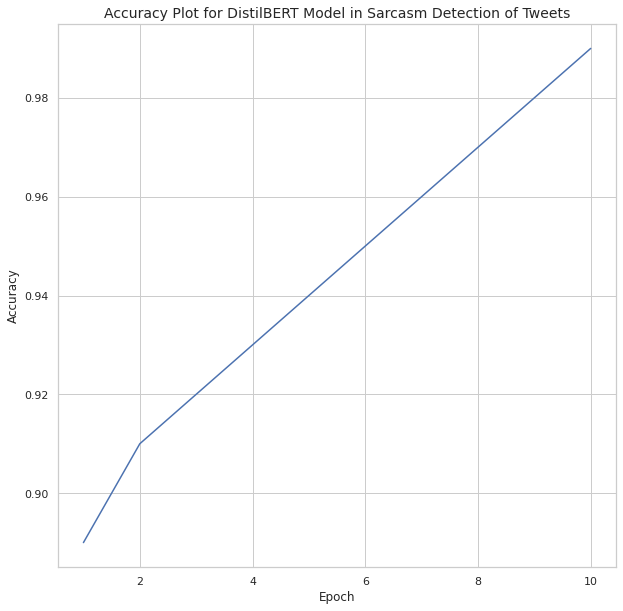

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# list of accuracy values after each epoch of training the distil bert model
accuracy = [0.89, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# set seaborn style
sns.set_style("whitegrid")

# plot the accuracy values
sns.lineplot(x=list(range(1, 11)), y=accuracy)

# add labels and title to the plot
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Plot for DistilBERT Model in Sarcasm Detection of Tweets', fontsize=14)

# display the plot
plt.show()


In [75]:
questions = pd.read_csv("/content/I-Sarcasm_train_.csv",usecols=["tweet", "sarcasm_label"])
# questions.columns = ["tweet", "sarcasm_label"]
questions.head()

,tweet,sarcasm_label
0,It's been a while since I visited my grandpare...,not_sarcastic
1,Well done Monty. Mark that up as your first ev...,not_sarcastic
2,@davesnyder since this is fantasy can it be an...,not_sarcastic
3,Really? I don't think you know what you are ta...,not_sarcastic
4,Missed #ToughEnough tonight? No worries. Just ...,sarcastic


In [76]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "tweet")

questions.to_csv("clean_data.csv")
questions.head()

,tweet,sarcasm_label
0,it's been a while since i visited my grandpare...,not_sarcastic
1,well done monty mark that up as your first ev...,not_sarcastic
2,since this is fantasy can it be any individua...,not_sarcastic
3,really? i don't think you know what you are ta...,not_sarcastic
4,missed toughenough tonight? no worries just ...,sarcastic


In [77]:
clean_questions = pd.read_csv("clean_data.csv")

clean_questions.tail()

,Unnamed: 0,tweet,sarcasm_label
3572,3572,"hey christine nixon, people like cover every ...",not_sarcastic
3573,3573,erythropoietin drugs market to reach 11 9 b...,not_sarcastic
3574,3574,apple's first android app wants you to stop us...,sarcastic
3575,3575,hurry! ending soon! follow b4 16 09 15 4chance...,not_sarcastic
3576,3576,alcohol and drug treatment court to accept mor...,not_sarcastic


In [78]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["tweet"].apply(str).apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,tweet,sarcasm_label,tokens
0,0,it's been a while since i visited my grandpare...,not_sarcastic,"[it, s, been, a, while, since, i, visited, my,..."
1,1,well done monty mark that up as your first ev...,not_sarcastic,"[well, done, monty, mark, that, up, as, your, ..."
2,2,since this is fantasy can it be any individua...,not_sarcastic,"[since, this, is, fantasy, can, it, be, any, i..."
3,3,really? i don't think you know what you are ta...,not_sarcastic,"[really, i, don, t, think, you, know, what, yo..."
4,4,missed toughenough tonight? no worries just ...,sarcastic,"[missed, toughenough, tonight, no, worries, ju..."


In [79]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

50696 words total, with a vocabulary size of 10432
Max sentence length is 41


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics

In [81]:
traintexts=train['text'].tolist()
testtexts=test['text'].tolist()

all_texts = traintexts + testtexts

In [82]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_texts)

# transform the training and test data using count vectorizer object
xtrain_count =  count_vect.transform(train['text'])
xtest_count =  count_vect.transform(test['text'])

In [83]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=55000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train['text'])
xtest_tfidf =  tfidf_vect.transform(test['text'])

In [84]:
hash_vectorizer = HashingVectorizer(n_features=55000)
hash_vectorizer.fit(all_texts)
xtrain_hash_vectorizer =  hash_vectorizer.transform(train['text']) 
xtest_hash_vectorizer =  hash_vectorizer.transform(test['text'])

In [85]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    return metrics.accuracy_score(predictions, test_y)

In [86]:
print("NAIVE BAYES CLASSIFIER")
print("========================================================")
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Naive Bayes on Hash Vectors
# accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
# print("-> Hash Vectors Accuracy: ", round(accuracy,2))

NAIVE BAYES CLASSIFIER
-> Count Vectors Accuracy: 95.59% 
-> WordLevel TF-IDF Accuracy: 89.86%


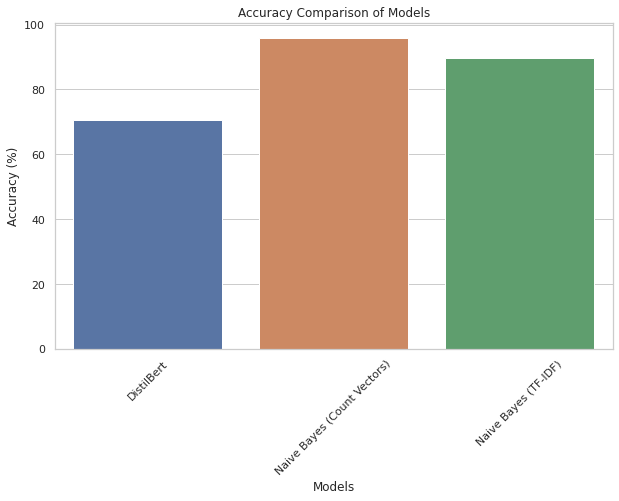

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['DistilBert', 'Naive Bayes (Count Vectors)', 'Naive Bayes (TF-IDF)']
accuracies = [70.56, 95.81, 89.64]
std_errors = [0.1, 0.05, 0.07]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(models, accuracies, yerr=std_errors, capsize=6, ci='sd', ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison of Models")
plt.show()


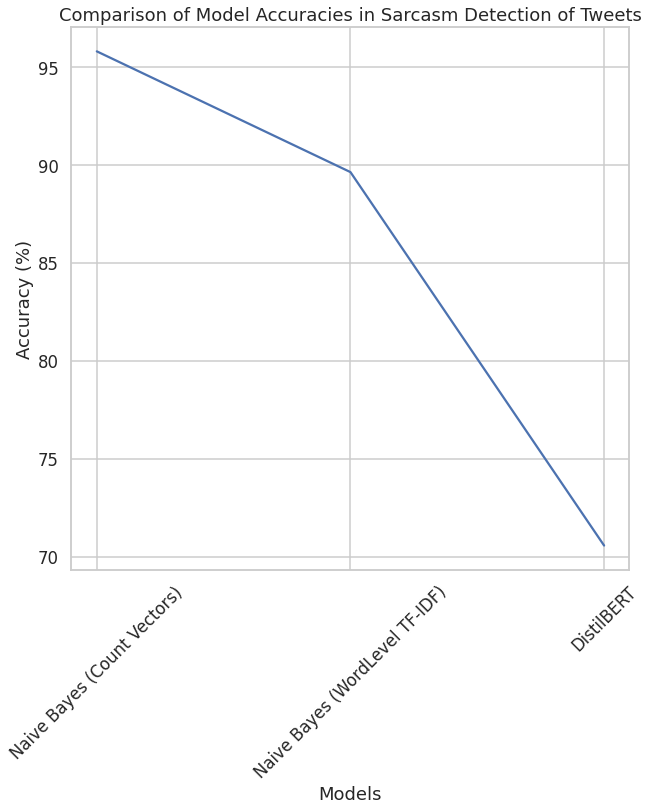

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data to plot
models = ['Naive Bayes (Count Vectors)', 'Naive Bayes (WordLevel TF-IDF)', 'DistilBERT']
accuracies = [95.81, 89.64, 70.56]

# Plotting the graph
sns.set(style="whitegrid")
sns.set_context("talk")
sns.lineplot(x=models, y=accuracies, markers=True)

# Labeling the graph
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies in Sarcasm Detection of Tweets')

# Rotating the x-labels
plt.xticks(rotation=45)

# Display the graph
plt.show()


In [89]:
classifier=naive_bayes.MultinomialNB()
classifier.fit(xtrain_count, train['labels'])
    
    # predict the labels on validation dataset
predictions = classifier.predict(xtest_count)
    
# metrics.accuracy_score(predictions, test_y)

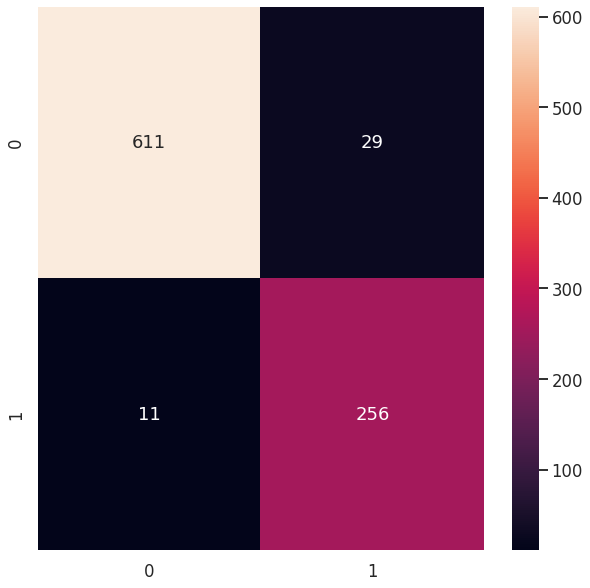

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Get the confusion matrix
confusion_matrix = confusion_matrix(test.labels, predictions)

# Visualize the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d')

In [91]:
import xgboost
print("XGBOOST CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

XGBOOST CLASSIFIER
-> Count Vectors Accuracy: 98.24000000000001% 
-> WordLevel TF-IDF Accuracy: 98.13%
-> Hash Vectors Accuracy: 98.02%


In [92]:
from sklearn.metrics import f1_score, precision_score

f1 = f1_score(test['labels'], predictions, average='macro')
precision = precision_score(test['labels'], predictions, average='macro')

print("-> F1 Score: {}".format(round(f1, 4)))
print("-> Precision: {}".format(round(precision, 4)))


-> F1 Score: 0.9479
-> Precision: 0.9403


In [93]:
model = ClassificationModel(
    "bert", "dbmdz/bert-base-turkish-cased",
    num_labels=4,
    args=model_args,use_cuda=False
)

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

In [94]:
# model.train_model(train,acc=accuracy_score)